# Import libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Database creations using pytorch Dataset 

In [ ]:
class ImageAuthenticityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def getInfo(self, idx):
        """
        Retrieves image Category, Challenge and prompt by index.
        
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (category, challenge, prompt) where:
                category (str): The category of the image.
                challenge (str): The challenge of the image.
                prompt (str): The prompt of the image.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        category = self.data.iloc[idx, 5]
        challenge = self.data.iloc[idx, 6]
        prompt = self.data.iloc[idx, 7]

        return category, challenge, prompt
    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([authenticity], dtype=torch.float)


        if self.transform:
            image = self.transform(image)

        return image, labels




# Definitions of the models

In [ ]:
class AuthenticityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Predict quality and realness
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features
    

## Setup section

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ANNOTATIONS_FILE = 'Dataset/AIGCIQA2023/real_images_annotations.csv'

# Create the dataset
dataset = ImageAuthenticityDataset(csv_file=ANNOTATIONS_FILE, transform=data_transforms)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 64
full_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create a dictionary containing the data loaders
dataloaders = {
    'full': full_dataloader,
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}

# Models loading

In [ ]:
BASELINE_MODEL_PATH = 'Weights/VGG-16_real_authenticity_finetuned.pth'
PRUNED_MODEL_PATH = 'Weights/authenticity_noise_out_pruned_model.pth'

model = AuthenticityPredictor()
model.load_state_dict(torch.load(BASELINE_MODEL_PATH,weights_only=True))

pruned_model = AuthenticityPredictor()
pruned_model.load_state_dict(torch.load(PRUNED_MODEL_PATH,weights_only=True))


Step 1: Feature Map Extraction
When an image travels through a neural network, each layer creates "activation maps" - essentially, each neuron lights up to different degrees based on what it sees in the image. These are like heatmaps showing what caught the network's attention.

In [ ]:

class FeatureMapHook:
    """Hook to extract feature maps from neural network layers."""
    
    def __init__(self):
        self.feature_maps = []
    
    def __call__(self, module, input, output):
        # Detach from computation graph and move to CPU
        self.feature_maps.append(output.detach().cpu())

def get_feature_maps(model, dataloader, device):
    """
    Extracts the feature maps of a specific layer from a model.
    
    Args:
        model (nn.Module): The neural network model.
        dataloader (DataLoader): DataLoader for evaluation.
        device (str): Device to run the model on ('cuda' or 'cpu').
        
    Returns:
        np.ndarray: The feature maps as a numpy array with shape (batch_size, num_features).
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Register a hook to extract feature maps
    hook = FeatureMapHook()
    
    hook_handle = model.features[28].register_forward_hook(hook)

    
    # Forward pass to extract feature maps from the dataloader
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    # Remove the hook
    hook_handle.remove()
    
    # Process the feature maps to get the desired shape
    all_features = []
    
    for batch_features in hook.feature_maps:
        # Add batch features to our collection
        all_features.append(batch_features)
    
    # Concatenate all batches and convert to numpy
    features_tensor = torch.cat(all_features, dim=0)
    
    # Ensure we have exactly the number of samples we expect in the dataloader 
    assert features_tensor.shape[0] == len(dataloader.dataset) 
    
    # Convert to numpy array
    features_array = features_tensor.numpy()
    
    return features_array

def plot_feature_map(feature_map, title=None):
    """
    Plots the feature map of a specific layer.
    
    Args:
        feature_map (np.ndarray): The feature map to plot.
        title (str, optional): Title for the plot.
    """
    # Plot the feature map
    plt.figure(figsize=(10, 10))
    plt.imshow(feature_map, cmap='jet')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()



Step 2: Define Hollow Square Templates
Here, we're creating reference patterns to compare against:

These are hollow square outlines of different sizes (using 50%, 60%, 70%, 80%, and 90% of the feature map's dimensions)
Only the edges of these squares are "on" - the interior is empty
Each template is centered in the same space as our feature maps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_hollow_square_templates_14x14():
    """
    Create hollow square templates specifically for 14×14 feature maps,
    ensuring perfect centering for all templates.
    
    Returns:
        Dictionary of templates with size ratios as keys
    """
    # Fixed feature map size
    feature_map_size = 14
    
    # These are the size ratios mentioned in the requirements
    size_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
    templates = {}
    
    # Pre-calculated exact positions for each ratio to ensure perfect centering
    # Format: (start_index, end_index) for a 14×14 grid
    positions = {
        0.5: (3, 10),   # 7×7 square (50% of 14)
        0.6: (3, 10),   # 8×8 square (rounded from 8.4×8.4)
        0.7: (2, 11),   # 10×10 square (rounded from 9.8×9.8)
        0.8: (1, 12),   # 12×12 square (rounded from 11.2×11.2)
        0.9: (0, 13)    # 14×14 square (rounded from 12.6×12.6)
    }
    
    for ratio in size_ratios:
        # Create empty template
        template = np.zeros((feature_map_size, feature_map_size))
        
        # Get pre-calculated positions
        start, end = positions[ratio]
        
        # Draw hollow square (only the edges)
        # Top edge
        template[start, start:end+1] = 1
        # Bottom edge
        template[end, start:end+1] = 1
        # Left edge
        template[start:end+1, start] = 1
        # Right edge
        template[start:end+1, end] = 1
        
        # Store template with its ratio
        templates[ratio] = template
    
    return templates

def visualize_templates(templates, feature_map_size=14):
    """
    Visualize all created templates to verify proper centering.
    """
    plt.figure(figsize=(15, 3))
    for i, (ratio, template) in enumerate(templates.items()):
        plt.subplot(1, len(templates), i+1)
        plt.imshow(template, cmap='gray')
        
        # Draw center point as a red dot
        center = feature_map_size / 2
        plt.plot(center, center, 'ro', markersize=3)
        
        # Calculate actual size of the square
        square_size = template.sum() / 4 + 1  # Divide by 4 sides and add 1 for corners
        
        plt.title(f"Ratio: {ratio}\nSize: {int(square_size)}×{int(square_size)}")
        plt.grid(True, linestyle='--', alpha=0.3)
        
    plt.tight_layout()
    plt.show()

Step 3: Match Templates to Feature Maps

For each feature map (i.e., each channel) in each image:
Compare the activation map to each of the square templates using a similarity measure (e.g., normalized cross-correlation or cosine similarity).
This yields one match score per square size.

In [ ]:
from scipy.stats import pearsonr

def compute_pearson_correlation(feature_map, template):
    """
    Compute Pearson correlation between a feature map and template.
    
    Args:
        feature_map: 2D numpy array of a single feature map
        template: 2D numpy array of template
        
    Returns:
        Pearson correlation coefficient
    """
    # Flatten arrays for correlation calculation
    feature_flat = feature_map.flatten()
    template_flat = template.flatten()
    
    # Calculate Pearson correlation
    correlation, _ = pearsonr(feature_flat, template_flat)
    
    # Handle NaN values (can happen if feature map is constant)
    if np.isnan(correlation):
        return 0.0
    
    return correlation
def match_templates_to_feature_maps(feature_maps, templates):
    """
    Match templates to feature maps and find best matches.
    
    Args:
        feature_maps: Tensor of shape [num_channels, height, width]
        templates: Dictionary of templates with size ratios as keys
        
    Returns:
        Dictionary with max scores and corresponding size ratios
    """
    num_channels = feature_maps.shape[0]
    results = {
        'max_scores': np.zeros(num_channels),
        'best_sizes': np.zeros(num_channels)
    }
    
    # Process each channel (feature map)
    for channel_idx in range(num_channels):
        # Get the feature map for this channel
        feature_map = feature_maps[channel_idx]
        
        max_score = -1.0
        best_size = 0.0
        
        # Compare with each template
        for size_ratio, template in templates.items():
            # Calculate correlation
            correlation = compute_pearson_correlation(feature_map, template)
            
            # Update if this is the best match so far
            if correlation > max_score:
                max_score = correlation
                best_size = size_ratio
        
        # Store results for this channel
        results['max_scores'][channel_idx] = max_score
        results['best_sizes'][channel_idx] = best_size
    
    return results



Step 4: Aggregate Results Across Images
Now analyze all this data to find patterns:

For each of the 512 spotlights, examine how well it matched squares across all images
Look for spotlights that consistently show high match scores (these might be "square detectors")
Look for spotlights with unusual score distributions - especially those that sometimes show very high matches (suggesting they only activate when squares are present)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from collections import defaultdict


def process_all_images(feature_maps_dataset, templates):
    """
    Process all images in the dataset to find hollow square detectors.
    
    Args:
        feature_maps_dataset: List or array of feature maps for each image
                             Each item has shape [num_channels, height, width]
        templates: Dictionary of templates with size ratios as keys
        
    Returns:
        all_scores: Dictionary with channel indices as keys, containing 
                    lists of scores for each image
        all_sizes: Dictionary with channel indices as keys, containing
                   lists of best size ratios for each image
    """
    # Initialize data structures to store results across all images
    all_scores = defaultdict(list)
    all_sizes = defaultdict(list)
    
    # Process each image
    for img_idx, feature_maps in enumerate(feature_maps_dataset):
        print(f"Processing image {img_idx+1}/{len(feature_maps_dataset)}")
        
        # Match templates to feature maps for this image
        results = match_templates_to_feature_maps(feature_maps, templates)
        
        # Store results for each channel
        for channel_idx in range(len(results['max_scores'])):
            all_scores[channel_idx].append(results['max_scores'][channel_idx])
            all_sizes[channel_idx].append(results['best_sizes'][channel_idx])
    
    return all_scores, all_sizes

def aggregate_results(all_scores, all_sizes):
    """
    Aggregate results across all images to identify channels that 
    consistently detect hollow squares.
    
    Args:
        all_scores: Dictionary with channel indices as keys, containing 
                    lists of scores for each image
        all_sizes: Dictionary with channel indices as keys, containing
                   lists of best size ratios for each image
                   
    Returns:
        channel_stats: DataFrame or dictionary with statistics for each channel
        top_channels: List of channel indices, sorted by average score
    """
    num_channels = len(all_scores)
    
    # Initialize arrays for statistics
    avg_scores = np.zeros(num_channels)
    avg_sizes = np.zeros(num_channels)
    score_stds = np.zeros(num_channels)
    size_stds = np.zeros(num_channels)
    
    # Calculate statistics for each channel
    for channel_idx in range(num_channels):
        scores = all_scores[channel_idx]
        sizes = all_sizes[channel_idx]
        
        avg_scores[channel_idx] = np.mean(scores)
        avg_sizes[channel_idx] = np.mean(sizes)
        score_stds[channel_idx] = np.std(scores)
        size_stds[channel_idx] = np.std(sizes)
    
    # Create channel statistics dictionary
    channel_stats = {
        'avg_score': avg_scores,
        'avg_size': avg_sizes,
        'score_std': score_stds,
        'size_std': size_stds
    }
    
    # Identify top channels by average score
    top_channels = np.argsort(avg_scores)[::-1]  # Sort in descending order
    
    return channel_stats, top_channels

def visualize_top_channels(feature_maps_dataset, top_channels, channel_stats, n_top=10, n_examples=5):
    """
    Visualize the top channels that detect hollow squares.
    
    Args:
        feature_maps_dataset: List or array of feature maps for each image
        top_channels: List of channel indices, sorted by average score
        channel_stats: Dictionary with statistics for each channel
        n_top: Number of top channels to visualize
        n_examples: Number of example images to show
        
    Returns:
        fig: Matplotlib figure object
    """
    # Limit the number of channels and examples
    n_top = min(n_top, len(top_channels))
    n_examples = min(n_examples, len(feature_maps_dataset))
    
    # Select example images (evenly spaced from dataset)
    example_indices = np.linspace(0, len(feature_maps_dataset)-1, n_examples, dtype=int)
    
    # Create figure
    fig, axes = plt.subplots(n_top, n_examples, figsize=(4*n_examples, 3*n_top))
    
    # Adjust for the case of a single row
    if n_top == 1:
        axes = axes.reshape(1, -1)
    
    # For each top channel
    for i, channel_idx in enumerate(top_channels[:n_top]):
        # Display average score and size in the row title
        avg_score = channel_stats['avg_score'][channel_idx]
        avg_size = channel_stats['avg_size'][channel_idx]
        row_title = f"Channel {channel_idx}: Avg Score = {avg_score:.4f}, Size = {avg_size:.2f}"
        
        # For each example image
        for j, img_idx in enumerate(example_indices):
            ax = axes[i, j]
            
            # Get feature map for this channel and image
            feature_map = feature_maps_dataset[img_idx][channel_idx]
            
            # Display the feature map
            im = ax.imshow(feature_map, cmap='viridis')
            
            # Set title for the first column
            if j == 0:
                ax.set_ylabel(row_title, fontsize=10)
            
            # Set title for the first row
            if i == 0:
                ax.set_title(f"Image {img_idx}")
            
            # Remove axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.suptitle("Top Feature Maps for Hollow Square Detection", y=1.02, fontsize=16)
    
    return fig

def analyze_square_detectors(feature_maps_dataset, templates, n_top=10, n_examples=5):
    """
    Main function to analyze hollow square detectors in feature maps.
    
    Args:
        feature_maps_dataset: List or array of feature maps for each image
                             Each item has shape [num_channels, height, width]
        templates: Dictionary of templates with size ratios as keys
        n_top: Number of top channels to report
        n_examples: Number of example images to visualize
        
    Returns:
        top_channels: List of top channel indices
        channel_stats: Dictionary with statistics for each channel
    """
    print("Processing all images...")
    all_scores, all_sizes = process_all_images(feature_maps_dataset, templates)
    
    print("Aggregating results...")
    channel_stats, top_channels = aggregate_results(all_scores, all_sizes)
    
    # Print top channels
    print(f"\nTop {n_top} channels for hollow square detection:")
    for i, channel_idx in enumerate(top_channels[:n_top]):
        avg_score = channel_stats['avg_score'][channel_idx]
        avg_size = channel_stats['avg_size'][channel_idx]
        score_std = channel_stats['score_std'][channel_idx]
        
        print(f"{i+1}. Channel {channel_idx}: " + 
              f"Avg Score = {avg_score:.4f}, " +
              f"Avg Size = {avg_size:.2f}, " +
              f"Score Std = {score_std:.4f}")
    
    # Visualize top channels
    # print("\nVisualizing top channels...")
    # fig = visualize_top_channels(feature_maps_dataset, top_channels, channel_stats, n_top, n_examples)
    
    # Optional: save the figure
    # fig.savefig('top_hollow_square_channels.png', dpi=300, bbox_inches='tight')
    
    return top_channels, channel_stats

In [ ]:
feature_maps = get_feature_maps(model, dataloaders['full'], device)
pruned_model_feature_maps = get_feature_maps(pruned_model, dataloaders['full'], device)
# templates = create_hollow_square_templates_14x14()

# top_channels, channel_stats = analyze_square_detectors(feature_maps, templates, n_top=100, n_examples=5)

In [ ]:
feature_maps = feature_maps.flatten()
pruned_model_feature_maps = pruned_model_feature_maps.flatten()
# plot distribution of the average feature map
plt.hist(feature_maps, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of base feature map values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# plot distribution of the average feature map
plt.hist(pruned_model_feature_maps, bins=50, color='red', alpha=0.7)
plt.title("Distribution of pruned Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()




In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import urllib.request
import tarfile
import shutil

def prepare_tiny_imagenet(root='Dataset'):
    """
    Download and prepare Tiny ImageNet dataset.
    
    Args:
        root: Root directory to store the dataset
        
    Returns:
        Path to the extracted dataset
    """
    tiny_imagenet_url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    tiny_imagenet_path = os.path.join(root, 'tiny-imagenet-200')
    
    # Create directory if it doesn't exist
    os.makedirs(root, exist_ok=True)
    
    # Download if needed
    if not os.path.exists(tiny_imagenet_path):
        zip_path = os.path.join(root, 'tiny-imagenet-200.zip')
        
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(tiny_imagenet_url, zip_path)
        
        print("Extracting Tiny ImageNet...")
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(root)
            
        # Remove zip file to save space
        os.remove(zip_path)
        
    return tiny_imagenet_path

class TinyImageNetDataset(Dataset):
    """Tiny ImageNet dataset."""
    
    def __init__(self, root, split='val', transform=None):
        """
        Args:
            root: Root directory of Tiny ImageNet dataset
            split: 'train' or 'val'
            transform: Optional transform to apply to images
        """
        self.root = root
        self.transform = transform
        self.split = split
        
        # For validation set
        if split == 'val':
            val_dir = os.path.join(root, 'val', 'images')
            self.image_paths = [os.path.join(val_dir, img) for img in os.listdir(val_dir)]
        
        # For training set
        else:
            self.image_paths = []
            train_dir = os.path.join(root, 'train')
            for class_dir in os.listdir(train_dir):
                class_path = os.path.join(train_dir, class_dir, 'images')
                if os.path.isdir(class_path):
                    self.image_paths.extend([os.path.join(class_path, img) 
                                            for img in os.listdir(class_path)])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # We don't need labels for our feature extraction
        return image, 0  # Dummy label

def load_tiny_imagenet_samples(num_samples=1000, batch_size=64):
    """
    Load Tiny ImageNet images for testing.
    
    Args:
        num_samples: Number of images to load
        batch_size: Batch size for the DataLoader
        
    Returns:
        DataLoader with Tiny ImageNet images
    """
    # Prepare dataset
    tiny_imagenet_path = prepare_tiny_imagenet()
    
    # Create transforms (same as for VGG16)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    dataset = TinyImageNetDataset(
        root=tiny_imagenet_path,
        split='val',  # Using validation set
        transform=transform
    )
    
    # Create subset if needed
    if num_samples < len(dataset):
        indices = torch.randperm(len(dataset))[:num_samples]
        dataset = torch.utils.data.Subset(dataset, indices)
    
    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )
    
    return dataloader

In [ ]:
base_model = vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Load ImageNet samples
imagenet_loader = load_tiny_imagenet_samples(num_samples=1000)

# Extract feature maps
print("Extracting feature maps from Tiny ImageNet...")
imagenet_feature_maps = get_feature_maps(model, imagenet_loader, device)

# Extract feature maps for pruned model
imagenet_pruned_feature_maps = get_feature_maps(pruned_model, imagenet_loader, device)

# Flatten the feature maps for easier processing
imagenet_feature_maps = imagenet_feature_maps.flatten()
imagenet_pruned_feature_maps = imagenet_pruned_feature_maps.flatten()

# Plot distribution of the average feature map for ImageNet
plt.hist(imagenet_feature_maps, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of ImageNet feature map values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot distribution of the average feature map for pruned model
plt.hist(imagenet_pruned_feature_maps, bins=50, color='red', alpha=0.7)
plt.title("Distribution of pruned ImageNet Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


/tmp/ipykernel_1448263/1911475478.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for the colorbar


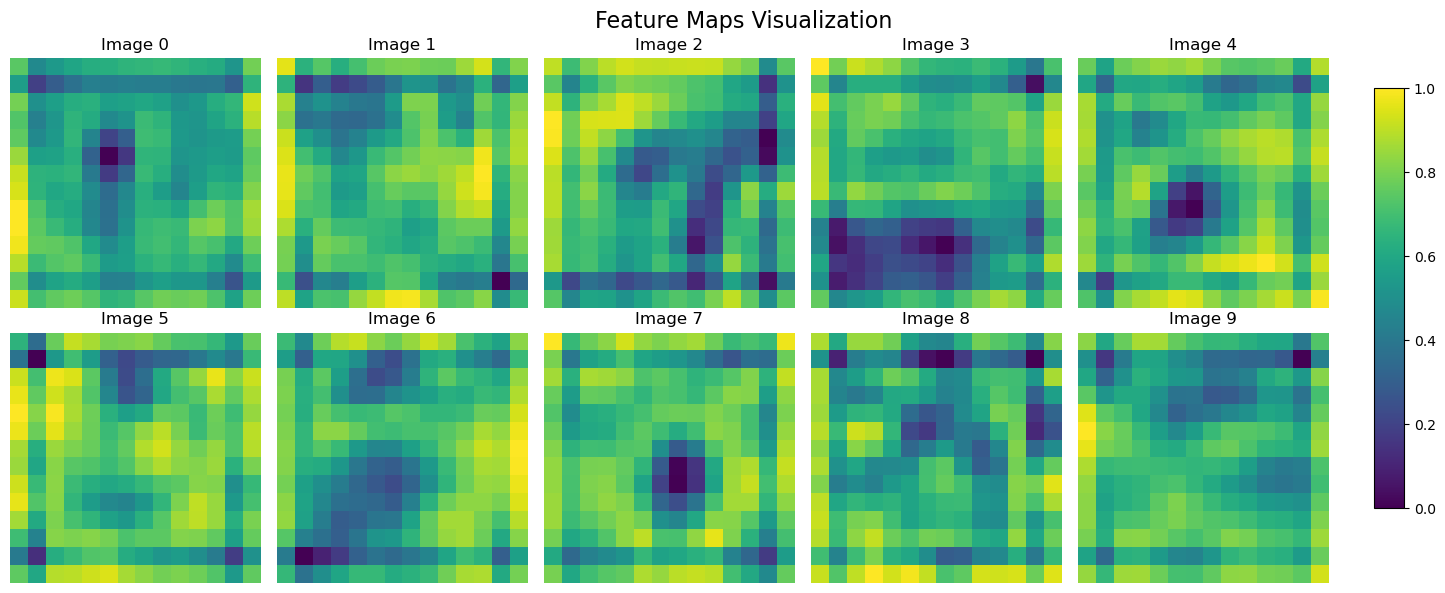

In [39]:
imagenet_feature_maps = get_feature_maps(model, imagenet_loader, device)

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each feature map in its own subplot
for i, feature_map in enumerate(imagenet_feature_maps):
    if i >= 10:
        break
    
    # Average across channels to get a 2D representation
    avg_feature_map = np.mean(feature_map, axis=0)
    # normalize to [0, 1] for better visualization
    avg_feature_map = (avg_feature_map - np.min(avg_feature_map)) / (np.max(avg_feature_map) - np.min(avg_feature_map))
    
    
    # Plot on the corresponding subplot
    ax = axes[i]
    im = ax.imshow(avg_feature_map, cmap='viridis')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Add a colorbar for reference
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for the colorbar
plt.suptitle("Feature Maps Visualization", fontsize=16)
plt.subplots_adjust(top=0.9)  # Make room for the title

# Show the entire figure with all subplots
plt.show()

/tmp/ipykernel_1448263/3808896781.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for the colorbar


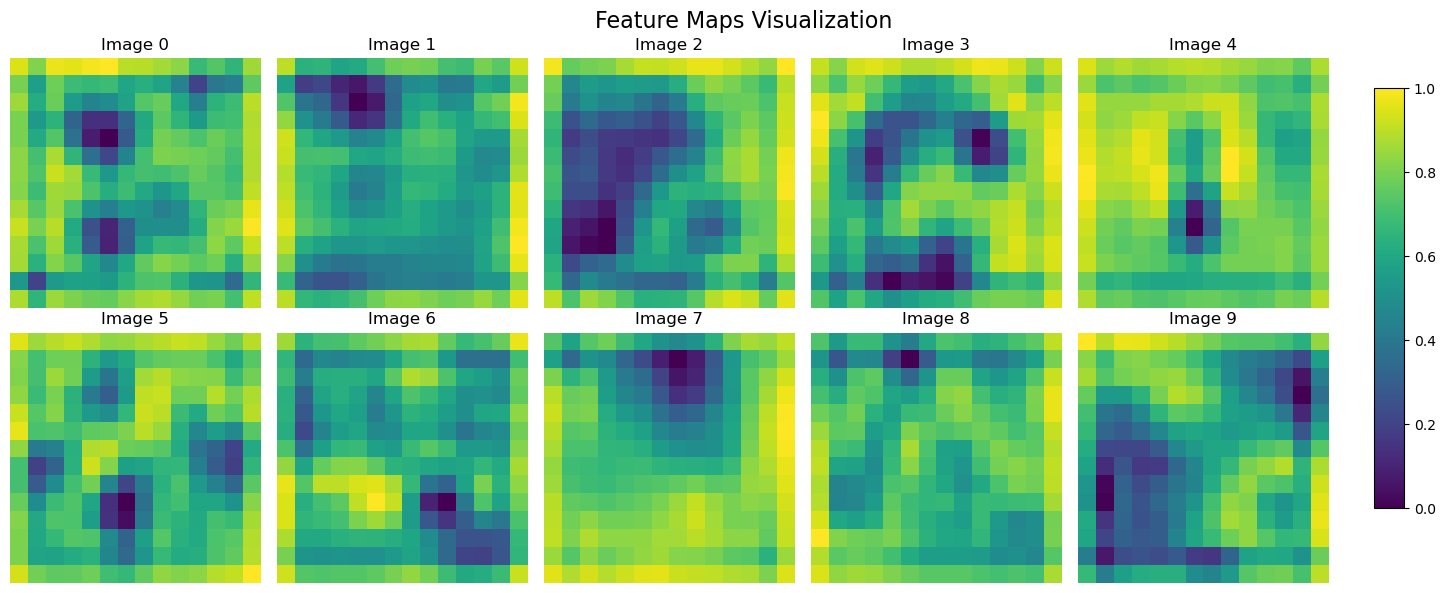

In [40]:
feature_maps = get_feature_maps(model, dataloaders['full'], device)

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each feature map in its own subplot
for i, feature_map in enumerate(feature_maps):
    if i >= 10:
        break
    
    # Average across channels to get a 2D representation
    avg_feature_map = np.mean(feature_map, axis=0)
    # normalize to [0, 1] for better visualization
    avg_feature_map = (avg_feature_map - np.min(avg_feature_map)) / (np.max(avg_feature_map) - np.min(avg_feature_map))
    
    
    # Plot on the corresponding subplot
    ax = axes[i]
    im = ax.imshow(avg_feature_map, cmap='viridis')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Add a colorbar for reference
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for the colorbar
plt.suptitle("Feature Maps Visualization", fontsize=16)
plt.subplots_adjust(top=0.9)  # Make room for the title

# Show the entire figure with all subplots
plt.show()